In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [5]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [6]:
latent_dim = 64

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim, activation="relu")
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(784, activation="sigmoid"),
            layers.Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [7]:
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [8]:
autoencoder.fit(x_train, x_train, epochs=10, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0240 - val_loss: 0.0134
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0090 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.008

In [9]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

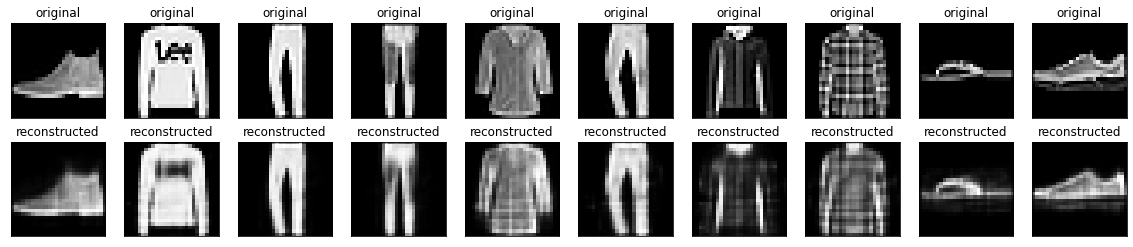

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Denoising

In [11]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [12]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [13]:
# 向图片中增加随机噪声
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0.0, clip_value_max=1.0)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0.0, clip_value_max=1.0)

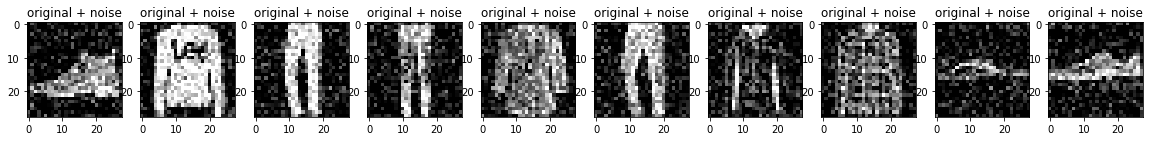

In [14]:
n = 10
plt.figure(figsize=(20, 2))
for i in  range(n):
    ax = plt.subplot(1, n, i+1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()

plt.show()

In [15]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(28, 28, 1)),
            layers.Conv2D(16, (3, 3), activation="relu", padding="same", strides=2),
            layers.Conv2D(8, (3, 3), activation="relu", padding="same", strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation="relu", padding="same"),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation="relu", padding="same"),
            layers.Conv2D(1, kernel_size=(3, 3), activation="sigmoid", padding="same")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [16]:
autoencoder.compile(optimizer="adam", loss=losses.MeanSquaredError())

In [17]:
autoencoder.fit(x_train_noisy, x_train, epochs=10, shuffle=True, validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 58s 31ms/step - loss: 0.0175 - val_loss: 0.0109
Epoch 2/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0097 - val_loss: 0.0090
Epoch 3/10
1875/1875 [==============================] - 59s 32ms/step - loss: 0.0087 - val_loss: 0.0084
Epoch 4/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 5/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 6/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 7/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 8/10
1875/1875 [==============================] - 60s 32ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 9/10
1875/1875 [==============================] - 61s 32ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 10/10
1875/1875 [==============================] - 61s 33m

In [18]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [19]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

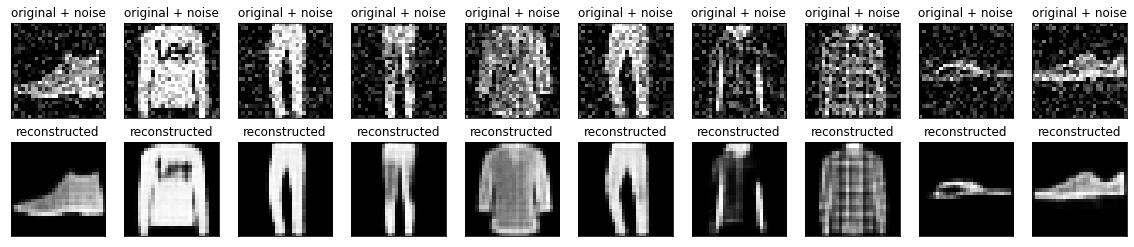

In [20]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("original + noise")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## 异常检测

In [22]:
import pandas as pd

dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [23]:
labels = raw_data[:, -1]
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [24]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [25]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

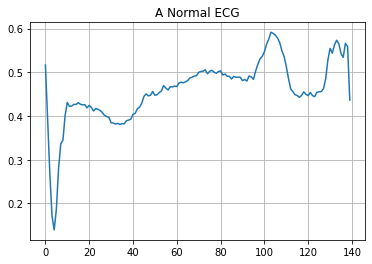

In [26]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

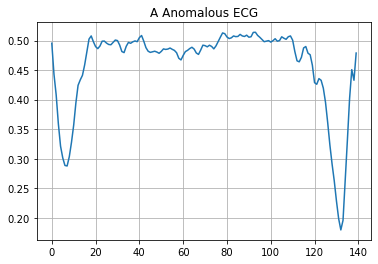

In [27]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("A Anomalous ECG")
plt.show()

In [28]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AnomalyDetector()

In [29]:
autoencoder.compile(optimizer="adam", loss="mae")

In [30]:
history = autoencoder.fit(normal_train_data, normal_train_data, epochs=20, batch_size=512, validation_data=(test_data, test_data), shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 19ms/step - loss: 0.0585 - val_loss: 0.0535
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 0.0555 - val_loss: 0.0517
Epoch 3/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0524 - val_loss: 0.0499
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0483 - val_loss: 0.0486
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0440 - val_loss: 0.0462
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0399 - val_loss: 0.0440
Epoch 7/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0418
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0336 - val_loss: 0.0407
Epoch 9/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0313 - val_loss: 0.0394
Epoch 10/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0296 - val_loss: 0.0384
Epoch 11/20
5/5 [==================

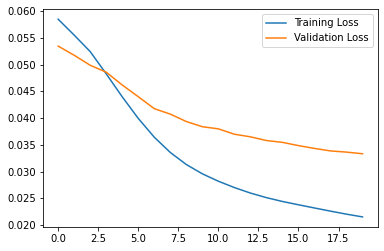

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

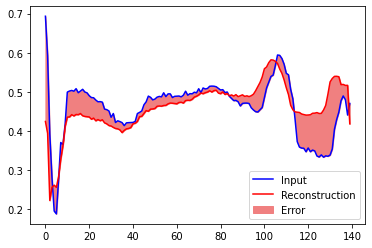

In [32]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

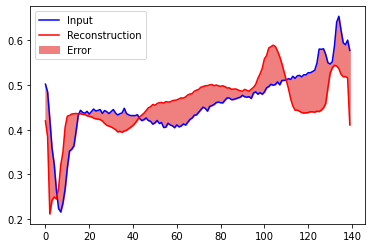

In [33]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

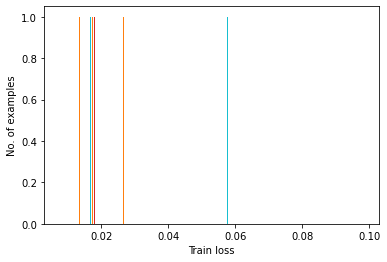

In [34]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No. of examples")
plt.show()

In [35]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold:", threshold)

Threshold: 0.033105433


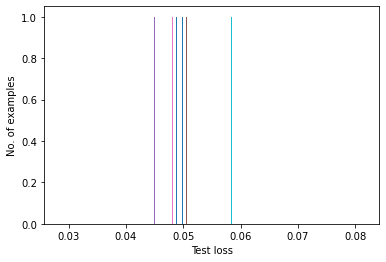

In [36]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No. of examples")
plt.show()

In [37]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

In [38]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.943
Precision = 0.9944444444444445
Recall = 0.9086294416243654
